# Fig 11-13 (comparison of S20 to M10 in $\tau$-$\sigma$ and $K$-$\hat{\sigma}$  plotting ratios and marginalized distributions )

Original code in `code2/Compare_Celerite_Chelsea_real_fits.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
import seaborn as sns
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

[Functions used (execute first these cells)](#functions)

[Fig.11: S20 vs M10](#fig11)

[Fig.12-13: S20 SDSS-PS1/SDSS  in sigma-tau and K-sigmaHat,  OBS: left hand sides](#fig12-13left)

[Fig.12-13: S20 SDSS-PS1/SDSS in sigma-tau and K-sigmaHat,  SIM: right hand sides](#fig12-13right)

### Function definitions <a id='functions'></a>

In [3]:
%matplotlib inline
import matplotlib.patches as patches
import matplotlib as mpl

#fname  = '190606_Celerite_real_Jeff1.txt'
#data = Table.read(fname, format='ascii')

#s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')
#data = s82r
#m2 = s82r['Plike'] - s82r['Pnoise'] > 2 
#m3 = s82r['Plike'] - s82r['Pinf'] > 0.05 
#m4 = s82r['edge'] == 0 
    
def plot_tau_sigma_ratios(data, M10compare =False,
                          extent=None, rectangle = None, seg = 'sdss',
                          figname = None, figtitle = None, z_axis = None,
                          print_stats = True, method = 'EXP',
                         choose_M10_subset = True, select_within_plot=False
                         ):
    ''' A convenience function to plot 
    log(tau_SDSS-PS1 / tau_SDSS) vs log(sigma_SDSS-PS1 / sigma_SDSS).
    
    By default, comparing Celerite to Celerite . 
    
    If M10compare,  then comparing tau_SDSS-PS1  celerite to tau_SDSS M10,
    or tau_SDSS to tau_SDSS M10 = which one is set in code
    
    rectangle = [x0,y0, width,height ] adds a red rectangle to 
    mark a given region if needed.
    
    method : MAP or EXP 
    
    '''
    fig = plt.figure(figsize=(9, 9))

    # an obvious cut, if nothing more stringent needed ... 
    #m5 = data['tauMAP_sdss-ps1'] > 0 
    m5 = data['tauEXP_sdss-ps1'] > 0 
    m = m5 #&m3&m4&m5
    print('For tau>0, we have ', np.sum(m), ' of ', len(m))
    
    if choose_M10_subset : 
        m2 = data['Plike'] - data['Pnoise'] > 2 
        m3 = data['Plike'] - data['Pinf'] > 0.05 
        m4 = data['edge'] == 0 
        print('For M10 good subset we have ', np.sum(m2*m3*m4), ' of ' , len(data))
        m = m2*m3*m4*m5
        print('Together we have ', np.sum(m), ' of ', len(m))


    if M10compare : 
        sigCel =  data['sigma'+method+'_'+seg][m] 
        tauCel =  data['tau'+method+'_'+seg][m] 
        sigM10 =  data['SFinf'][m] / np.sqrt(2)
        tauM10 =  np.power(10, data['log10tau'][m]) 
        x  = np.log10(sigCel / sigM10)
        y  = np.log10(tauCel / tauM10)
        if not extent : 
            extent = [-0.25, 0.1, -0.5, 0.5 ]
    

    if not M10compare:  
        x = np.log10(data['sigma'+method+'_sdss-ps1'][m] /\
                     data['sigma'+method+'_sdss'][m] )
        y = np.log10(data['tau'+method+'_sdss-ps1'][m]  /\
                     data['tau'+method+'_sdss'][m] )
        if not extent : 
            extent = [-0.2, 0.7, -1., 1.5 ]
    
    xmin,xmax = extent[0], extent[1]
    ymin,ymax = extent[2], extent[3]

    if select_within_plot :
        # select data only within the plot ... 
        xmask  = (xmin<x)*(x<xmax)
        ymask  = (ymin<y)*(y<ymax)

        x = x[xmask*ymask]
        y = y[xmask*ymask]

    # main axis : the hexbin 
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    image = ax1.hexbin(x, y, extent = extent, gridsize=35, 
          bins='log', vmin=1 , mincnt=2, cmap='magma')
    
    
    # add colorbar ... 
    vmin, vmax = image.get_clim()
    norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
    cmap.set_array([])
    left, bottom, width, height = 0.95, 0.4, 0.03, 0.55
    cax = fig.add_axes([left,bottom,width,height])
    plt.colorbar(mappable = cmap, cax = cax, orientation='vertical',
                label=r'$\log_{10}{(\mathrm{count})}$')
    ls='--'; lw = 3 ;c='orange'
    ax1.axvline(0,ls=ls,lw=lw,c=c)
    ax1.axhline(0,ls=ls,lw=lw,c=c)
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
    
    
    #xmin,xmax = ax1.get_xlim()
    #xx  = np.linspace(xmin,xmax)
    #ax1.plot(xx,ls='--',lw=3,c='r')

    # second axis, marginalizing along x 
    left, bottom, width, height = 0.1, 0.4, 0.29, 0.55
    ax2 = fig.add_axes((left, bottom, width, height))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    hist_y, bins_y = np.histogram(y, bins=33, density=True, range=extent[2:])
    ax2.plot(hist_y, 0.5 * (bins_y[1:] + bins_y[:-1] - bins_y[1] + bins_y[0]),
             '-k', drawstyle='steps')
    ax2.set_ylim(ymin,ymax)
    

    # third axis, marginalizing along y 
    # third axis: marginalized over gamma
    left, bottom, width, height = 0.4, 0.1, 0.55, 0.29
    ax3 = fig.add_axes((left, bottom, width, height))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    hist_x, bins_x = np.histogram(x, bins=33, density=True, range=extent[:2])
    ax3.plot(0.5 * (bins_x[1:] + bins_x[:-1]), hist_x,
             '-k', drawstyle='steps-mid')
    ax3.set_xlim(xmin,xmax)
    
    # add bias and sigmaG  info... bias is median 
    if print_stats : 
        dy = 0.04
        x0,y0 = 0.1, 0.32 
        sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
        fig.text(x0,y0,r'$\sigma_{G}(\tau_{\mathrm{ratio}})=%.3f$'% \
                 sigmaG(np.power(10,y)),
                fontsize=18)
        bias = np.median(np.power(10,y)) - 1 
        fig.text(x0,y0-dy,r'$\mathrm{bias}(\tau_{\mathrm{ratio}})=%.3f$'% \
                 bias,
                fontsize=18)


        fig.text(x0,y0-3*dy,r'$\sigma_{G}(\sigma_{\mathrm{ratio}})=%.3f$'% \
                 sigmaG(np.power(10,x)),
                fontsize=18)
        bias = np.median(np.power(10,x)) - 1
        fig.text(x0,y0-4*dy,r'$\mathrm{bias}(\sigma_{\mathrm{ratio}})=%.3f$'% \
                 bias,
                fontsize=18)
    
    if rectangle  : 
        # add a red rectangle ..
        x0, y0, w, h = rectangle
        rect = patches.Rectangle((x0,y0),w,h, linewidth=1,
                                 edgecolor='r',facecolor='red', alpha=0.5)
        # Add the patch to the Axes
        ax1.add_patch(rect)
        
        # count objects in the tail-end of the distribution ... 
        maskX = (x0<x)# * (x < (x0+w))
        maskY = (y0<y)# * (y < (y0+h))
        maskObj = maskX * maskY
        print('\nThere are %d objects with x > %.2f, y > %.2f '%\
              (np.sum(maskObj), x0, y0))
        
        # count objects in the rectangle 
        maskX = (x0<x) * (x < (x0+w))
        maskY = (y0<y) * (y < (y0+h))
        maskObj = maskX * maskY
        print('\nThe are %d objects in the rectangle'%np.sum(maskObj))
        
        
    if M10compare : 
        string = r'$\log_{10}{\left( \sigma_{S20} / \sigma_{M10} \right)}$'
        ax3.set_xlabel(string, fontsize=22)
        string = r'$\log_{10}{\left( \tau_{S20} / \tau_{M10} \right)}$'
        ax2.set_ylabel(string,fontsize=22)
        
        if figname is None : 
            figname = 'Compare_Chelsea_r-band_Celerite_'+seg+\
            '_'+method+'_NEW_single_.png'

    if not M10compare : 
        
        string = r'$\log_{10}{\left( \sigma_{\mathrm{%s}} / \sigma_{\mathrm{%s}} \right)}$'%('SDSS-PS1','SDSS')
        ax3.set_xlabel(string, fontsize=22)
        string = r'$\log_{10}{\left( \tau_{\mathrm{%s}} / \tau_{\mathrm{%s}} \right)}$'%('SDSS-PS1','SDSS')
        ax2.set_ylabel(string, fontsize=22)
        if  figname is None : 
            figname = 'Compare_Celerite_SDSS-PS1_vs_SDSS_'+\
            method+'_'+fname[:6]+'.png'
        
    ax1.set_title(figtitle,fontsize=22 )
    
    print('Saved as ',  figname)
    plt.savefig(figname,  
                bbox_inches='tight', dpi=100)

In [7]:
import matplotlib.patches as patches
import matplotlib as mpl

def plot_K_sigma_hat(data,  M10compare =False, extent=None, rectangle = None,
                    figname = None, figtitle = None ,
                    print_stats  = True , seg = 'sdss', choose_M10_subset=True):
    ''' A convenience function to plot 
    the changes in DRW parameters between SDSS and SDSS-PS1 
    when using Celerite  in K-sigmahat space 
    (rather than tau-sigma)
    

    rectangle = [x0,y0, width,height ] adds a red rectangle to 
    mark a given region if needed.

    
    '''
    fig = plt.figure(figsize=(9, 9))

    # an obvious cut, if nothing more stringent needed ... 
    m5= data['tauMAP_sdss-ps1'] > 0 
    m = m5
    print(np.sum(m), ' of ', len(m))
    
    if choose_M10_subset : 
        m2 = data['Plike'] - data['Pnoise'] > 2 
        m3 = data['Plike'] - data['Pinf'] > 0.05 
        m4 = data['edge'] == 0 
        print('For M10 good subset we have ', np.sum(m2*m3*m4), ' of ' , len(data))
        m = m2*m3*m4*m5
        print('Together we have ', np.sum(m), ' of ', len(m))

        
        
    if M10compare :  # seg is SDSS by default ... 
        sigma1 =  data['sigmaEXP_'+seg][m] 
        tau1=  data['tauEXP_'+seg][m] 
        sigma2 =  data['SFinf'][m] / np.sqrt(2)  # M10 
        tau2 =  np.power(10, data['log10tau'][m])  # M10 
    
    if not M10compare : 
        sigma1 = data['sigmaEXP_sdss-ps1'].data
        sigma2 = data['sigmaEXP_sdss'].data
        tau1 = data['tauEXP_sdss-ps1'].data
        tau2 = data['tauEXP_sdss'].data 
        
    sigma_hat_12 = (sigma1/sigma2) * np.sqrt(tau2/tau1)
    K_12 = (tau1/tau2) * np.sqrt(sigma1/sigma2)

    x = np.log10(sigma_hat_12)
    y = np.log10(K_12)
    
    if not extent : 
        extent = [-0.2, 0.7, -1., 1.5 ]

    xmin,xmax = extent[0], extent[1]
    ymin,ymax = extent[2], extent[3]

    # main axis : the hexbin 
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    image = ax1.hexbin(x, y, extent = extent, gridsize=35, 
          bins='log', vmin=1 , mincnt=2, cmap='magma')

    # add colorbar ... 
    vmin, vmax = image.get_clim()
    norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
    cmap.set_array([])
    left, bottom, width, height = 0.95, 0.4, 0.03, 0.55
    cax = fig.add_axes([left,bottom,width,height])
    plt.colorbar(mappable = cmap, cax = cax, orientation='vertical',
                label=r'$\log_{10}{(\mathrm{count})}$')
    ls='--'; lw = 3 ;c='orange'
    ax1.axvline(0,ls=ls,lw=lw,c=c)
    ax1.axhline(0,ls=ls,lw=lw,c=c)
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
    
    
    #xmin,xmax = ax1.get_xlim()
    #xx  = np.linspace(xmin,xmax)
    #ax1.plot(xx,ls='--',lw=3,c='r')

    # second axis, marginalizing along x 
    left, bottom, width, height = 0.1, 0.4, 0.29, 0.55
    ax2 = fig.add_axes((left, bottom, width, height))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    hist_y, bins_y = np.histogram(y, bins=33, density=True, range=extent[2:])
    ax2.plot(hist_y, 0.5 * (bins_y[1:] + bins_y[:-1] - bins_y[1] + bins_y[0]),
             '-k', drawstyle='steps')
    ax2.set_ylim(ymin,ymax)

    # third axis, marginalizing along y 
    # third axis: marginalized over gamma
    left, bottom, width, height = 0.4, 0.1, 0.55, 0.29
    ax3 = fig.add_axes((left, bottom, width, height))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    hist_x, bins_x = np.histogram(x, bins=33, density=True, range=extent[:2])
    ax3.plot(0.5 * (bins_x[1:] + bins_x[:-1]), hist_x,
             '-k', drawstyle='steps-mid')
    ax3.set_xlim(xmin,xmax)
    
    # add bias and sigmaG  info... bias is 1-median 
    if print_stats : 
        dy = 0.04
        x0,y0 = 0.1, 0.32 
        sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
        fig.text(x0,y0,r'$\sigma_{G}(\mathrm{K_{ratio}})=%.3f$'% \
                 sigmaG(np.power(10,y)),
                fontsize=18)
        bias = np.median(np.power(10,y)) - 1 
        fig.text(x0,y0-dy,r'$\mathrm{bias}(\mathrm{K_{ratio}})=%.3f$'% \
                 bias,
                fontsize=18)


        fig.text(x0,y0-3*dy,r'$\sigma_{G}(\hat{\sigma}_{\mathrm{ratio}})=%.3f$'% \
                 sigmaG(np.power(10,x)),
                fontsize=18)
        bias  = np.median(np.power(10,x)) -1 
        fig.text(x0,y0-4*dy,r'$\mathrm{bias}(\hat{\sigma}_{\mathrm{ratio}})=%.3f$'% \
                 bias,
                fontsize=18)
    
    
    if rectangle  : 
        # add a red rectangle ..
        x0, y0, w, h = rectangle
        rect = patches.Rectangle((x0,y0),w,h, linewidth=1,
                                 edgecolor='r',facecolor='red', alpha=0.5)
        # Add the patch to the Axes
        ax1.add_patch(rect)

    # axis title, labels   ....
    if M10compare : 
        
        stringx = r'$\log_{10}{\left( \hat{\sigma}_{S20} / \hat{\sigma}_{M10} \right)}$'
        ax3.set_xlabel(stringx, fontsize=22)
        
        stringy = r'$\log_{10}{\left( \mathrm{K}_{S20} / \mathrm{K}_{M10}\right)}$'
        ax2.set_ylabel(stringy, fontsize=22)
        if  not figname : 
            figname = 'Compare_Celerite_Chelsea_K-sigma-hat_'+\
            fname[:6]+'.png'
            
    if not M10compare : 
        segs =  ('SDSS-PS1','SDSS')
        
        stringx = r'$\log_{10}{\left( \hat{\sigma}_{%s} / \hat{\sigma}_{%s} \right)}$'%segs
        ax3.set_xlabel(stringx, fontsize=22)
        
        stringy = r'$\log_{10}{\left( \mathrm{K}_{%s} / \mathrm{K}_{%s}\right)}$'%segs
        ax2.set_ylabel(stringy, fontsize=22)
        if  not figname : 
            figname = 'Compare_Celerite_SDSS-PS1_vs_SDSS_EXP_K-sigma-hat_'+\
            fname[:6]+'.png'

    ax1.set_title(figtitle,fontsize=22 )
    
    print('Saved as ',  figname)
    plt.savefig(figname,  
                bbox_inches='tight', dpi=100)

## Data source  for SDSS-PS1 light curves used for fitting 


Notebook `/code2/Combine_PS1_SDSS_clean_NEW.ipynb` explains what has been done. In particular:
    
* Notebook `code2/Combine_PS1_SDSS_clean.ipynb` combined SDSS r and PS1 r  DR2. Stored the raw 8516 light curves (no offsets needed) in `/dp2/real_sdss_ps1r_dr2/`
* These light curves were cleaned and visually inspected, removing certain epochs . The outcome (also 8516)  light curves are in `dp2/real_sdss_ps1r_dr2_cleaned_NEW/`. The illustration of what was done is in `/dp2/figs/SDSS_PS1_DR2_190807_cleaned/` which shows the SDSS-PS1 raw and cleaned light curves.  In particular, we : 
  * removed points that have error > 1 mag (bad)
  * removed points that have mag > 30 (bad)
  * removed points before MJD=50000 (bad)
  * calculated median(SDSS-PS1 error), and sigmaG(error) , removed points further than 7 stdev from the median 
  * calculated median(SDSS-PS1 mag), and sigmaG(SDSS-PS1 mag) - if there were any points that depart by more than 7stdev, flagged as `flares`, later inspected visually whether these need be removed
  * in day-averaging, ignored any points that were flagged  as `flares`
  
* The light curves from `dp2/real_sdss_ps1r_dr2_cleaned_NEW` were fitted with DRW model using Celerite in notebook `Fit_real_combined_LC_3_NEW.ipynb` , with prior `Jeff1`, and limits `sig_lims , tau_lims = [0.02,0.7], [0.1,5000]`  ;  results are in `code2/190807_Celerite_real_Jeff1.npy1`.

* The Celerite results were combined with Chelsea results and Shen2008-2011 QSO catalogs in notebook `code2/Compare_Celerite_Chelsea_real_fits.ipynb#add_catalogs.ipynb`, to `190807_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt`

## RESUBMITTED  - FIG.11 : COMPARE TO S20 TO M10 <a id='fig11'></a>

In [9]:
data

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ztf,sigmaEXP_sdss-ps1-ztf,sigmaMAP_sdss-ps1-ztf,tauEXP_sdss-ps1-ztf,tauMAP_sdss-ps1-ztf,length_sdss-ps1-ztf-lsst,sigmaEXP_sdss-ps1-ztf-lsst,sigmaMAP_sdss-ps1-ztf-lsst,tauEXP_sdss-ps1-ztf-lsst,tauMAP_sdss-ps1-ztf-lsst
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1000679.txt,3336.9561299999987,0.17372380569999685,0.14026633970440283,901.2549220205265,330.65219754004096,5513.069991199998,0.15282895376187547,0.13037812507728735,678.8407344604589,280.18749728324053,7400.655313333336,0.21845250606638367,0.18569149099829815,1227.4811191286226,659.4407028340986,12510.862307827825,0.1637847722689818,0.14711022461483023,816.2739924648492,567.9502734496259
1000743.txt,3336.956146000004,0.1368924587173323,0.11364229981563599,723.5923276915645,353.7416432791509,5895.950533700001,0.12255502658653772,0.10747667325465646,543.5943333755741,321.6020935717062,7400.657342333339,0.15131190166993663,0.13083091378973663,875.7424246407091,516.1782708263167,12510.864336827828,0.1291083623879221,0.11829328695521081,549.7800744545492,413.1670880421176
1001265.txt,3327.0175859999945,0.1278473770005897,0.10958206741552913,463.3026806023565,197.7410369500242,5895.961819099997,0.10747136582652535,0.09860171296536265,268.47546522159604,159.89563408187433,7400.655709333332,0.12404974167730985,0.11187619238095613,479.14647545251535,283.1419594162298,12510.862703827821,0.12461025307166444,0.11425253895903822,498.73898645396235,373.9299516106872
1001294.txt,2582.9626130000033,0.15084302525421023,0.12043543886330232,1531.405683455064,524.551784773845,4767.9674503999995,0.1357906360823151,0.1121958933887647,1593.7357770746266,615.9820058621011,6656.606566333336,0.13042297576868905,0.11255240707400734,1193.5031875764898,478.4737479880702,11766.813560827824,0.16869247609249594,0.1490071255290454,1024.2387967242287,674.4181870157629
1001531.txt,3336.956121999996,0.11404255174058053,0.09745731459113148,391.3216028221721,170.4619483183812,5513.060385699995,0.14933624610888457,0.12947403146234374,568.5209292596268,284.80081094344246,7400.6579483333335,0.19186133221658042,0.16580416054642824,924.6413497443242,485.9177508890032,12510.864942827822,0.13531251570547467,0.12208295256598165,613.9590373536856,428.7406811391257
1001793.txt,3336.956118000002,0.13798294630388874,0.11219485650634964,770.0430220271859,328.31551934510287,5513.073767199996,0.20188379070898954,0.16428889860055934,1598.5436674195957,784.3138434721709,7400.659089333334,0.16774968464428502,0.14320815094112613,1080.31358039459,601.2152986756748,12510.866083827823,0.1317040047592262,0.12013870361914308,535.2161146350613,392.64765084894753
1002076.txt,3336.9563599999965,0.09311038573192731,0.0828844037832651,171.76671910186846,88.16585785223775,5895.991951399999,0.09531478998097968,0.08693735169040959,147.25353735575806,85.16096813221303,7400.660229333334,0.12675458478616947,0.11364257867846238,379.50947582515954,209.49963050433354,12510.867223827823,0.10826640914790464,0.1015805329496339,309.4753770330168,252.82746379652804
1002162.txt,3321.0338460000057,0.12802828308357597,0.11040904064842405,404.09403632822296,211.01920018006342,5890.0101001,0.12288515413195723,0.11140329607462993,352.2105781433354,229.79158497414556,7394.6790473333385,0.1395593150432647,0.12424084741992789,557.0684632894122,351.8876240233225,12504.886041827827,0.12972020463031236,0.11950693819136203,553.712588200369,424.9883798298049
1002453.txt,3321.033841999997,0.18996693882209073,0.1545414701446226,1885.0415070488611,1012.8098738811757,5506.039444399998,0.17245221574111386,0.1429220981440909,1788.9572979591867,979.4474526846004,7394.678560333334,0.15136941368925189,0.12847217477441006,1327.2824082964207,729.9711556690961,12504.885554827822,0.161229

In [20]:
dataDir = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/'
date = '190807'#'190807'#'190606'#'190807'#'190807'
data = Table.read(dataDir + date+'_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')

method = 'EXP'
m = data['tauEXP_sdss-ps1'] > 0 
print('For tau>0, we have ', np.sum(m), ' of ', len(m))

x = np.log10(data['sigma'+method+'_sdss-ps1'][m] /\
             data['sigma'+method+'_sdss'][m] )
y = np.log10(data['tau'+method+'_sdss-ps1'][m]  /\
             data['tau'+method+'_sdss'][m] )

extent = [-0.2,0.7,-1,1.5]
xmin,xmax = extent[0], extent[1]
ymin,ymax = extent[2], extent[3]

select_within_plot = False
if select_within_plot :
    # select data only within the plot ... 
    xmask  = (xmin<x)*(x<xmax)
    ymask  = (ymin<y)*(y<ymax)

    x = x[xmask*ymask]
    y = y[xmask*ymask]
     
        
rectangle =  [0.4,1.0, 0.3,0.5]  
x0, y0, w, h = rectangle

# count objects in the tail-end of the distribution ... 
maskX = (x0<x)# 
maskY = (y0<y)# 
maskObj = maskX * maskY
print('\nThere are %d objects with x > %.2f, y > %.2f '%\
      (np.sum(maskObj), x0, y0))

# count objects in the rectangle 
maskX = (x0<x) * (x < (x0+w))
maskY = (y0<y) * (y < (y0+h))
maskObj = maskX * maskY
print('\nThe are %d objects in the rectangle'%np.sum(maskObj))
        

For tau>0, we have  8516  of  8516

There are 65 objects with x > 0.40, y > 1.00 

The are 48 objects in the rectangle


In [22]:
np.ravel(data.colnames)

array(['lcname', 'length_sdss', 'sigmaEXP_sdss', 'sigmaMAP_sdss',
       'tauEXP_sdss', 'tauMAP_sdss', 'length_sdss-ps1',
       'sigmaEXP_sdss-ps1', 'sigmaMAP_sdss-ps1', 'tauEXP_sdss-ps1',
       'tauMAP_sdss-ps1', 'dbID', 'ra_1', 'dec_1', 'SDR5ID_1', 'M_i_1',
       'M_i_corr', 'redshift_1', 'mass_BH_1', 'Lbol', 'u', 'g', 'r', 'i',
       'z', 'Au', 'SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 'LOGLBOL',
       'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO', 'MI_Z2', 'd2d_chelsea',
       'SDR5ID_2', 'ra_2', 'dec_2', 'redshift_2', 'M_i_2', 'mass_BH_2',
       'chi2_pdf', 'log10tau', 'log10sigmahat', 'log10tau_lim_lo',
       'log10tau_lim_hi', 'log10sigmahat_lim_lo', 'log10sigmahat_lim_hi',
       'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts', 'SFinf',
       'lambdaRF'], dtype='<U20')

In [27]:
# count objects in the tail-end of the distribution ... 
maskX = ((x0+w)<x)# 
maskY = ((y0+h)<y)# 
maskObj = maskX | maskY
method = 'EXP'
data['log10tauEXP_sdss'] = np.log10(data['tau'+method+'_sdss'])
data['log10tauEXP_sdss-ps1'] = np.log10(data['tau'+method+'_sdss-ps1'])
data['log10sigmaEXP_sdss'] = np.log10(data['sigma'+method+'_sdss'])
data['log10sigmaEXP_sdss-ps1']= np.log10(data['sigma'+method+'_sdss-ps1'])

data['x'] = np.log10(data['sigma'+method+'_sdss-ps1'] /\
             data['sigma'+method+'_sdss'] )
data['y'] =  np.log10(data['tau'+method+'_sdss-ps1']  /\
             data['tau'+method+'_sdss'])

data[maskObj][['lcname', 'Npts', 'log10tau','log10tauEXP_sdss','log10tauEXP_sdss-ps1',
               'log10sigmaEXP_sdss','log10sigmaEXP_sdss-ps1','x','y',
               'tauEXP_sdss','tauEXP_sdss-ps1', 'length_sdss-ps1','length_sdss',
               'sigmaEXP_sdss','sigmaEXP_sdss-ps1', 'REDSHIFT','LOGBH' ]]

lcname,Npts,log10tau,log10tauEXP_sdss,log10tauEXP_sdss-ps1,log10sigmaEXP_sdss,log10sigmaEXP_sdss-ps1,x,y,tauEXP_sdss,tauEXP_sdss-ps1,length_sdss-ps1,length_sdss,sigmaEXP_sdss,sigmaEXP_sdss-ps1,REDSHIFT,LOGBH
str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
226040.txt,62,1.13384,0.8713039713456093,2.977670106530006,-1.3467852930220299,-0.8955389602036884,0.4512463328183415,2.1063661351843965,7.4353937380978845,949.8829810352918,5512.053447700004,3336.9332850000064,0.04500022725217913,0.1271923641735177,1.6068999767303467,8.406705980165308
336603.txt,56,3.61138,2.408334067181966,3.456920509212915,-1.5481763498125283,-0.7415509680224374,0.8066253817900909,1.0485864420309492,256.05547546614577,2863.6537750671364,5505.053926500004,3321.0338279999996,0.02830242512888479,0.18132138678521717,2.363800048828125,9.263942359631688
467617.txt,55,0.947754,1.635749761351496,3.20489018462883,-1.353311585193743,-0.9443895531459084,0.40892203204783456,1.5691404232773336,43.22646901738733,1602.8400465340742,5118.9706883000035,2934.938753000002,0.04432904904223857,0.11366073152494331,1.8202999830245972,7.861114250153374
586347.txt,61,2.68929,2.867264896219339,-0.9999946528298037,-0.9855912521947588,-0.16106407291800334,0.8245271792767555,-3.867259549049143,736.6562811071882,0.10000123123901805,5895.975250999996,3336.933315999995,0.10337338741936108,0.690137977964077,3.2588000297546387,9.52760534164068
751557.txt,4,-10.0,0.8853278774976612,2.4866931402986165,-0.8797703191832964,-0.32523419199819664,0.5545361271850997,1.6013652628009556,7.6794103981489314,306.6854273674961,2918.1116526999976,332.0341600000029,0.13189540957061696,0.4728961823435043,0.5335999727249146,8.87780333233864
1137239.txt,56,1.23061,1.1573082491049673,2.707064852852211,-1.3006968826405596,-0.9603209202390423,0.3403759624015173,1.5497566037472439,14.365086620591804,509.4069347132972,5054.200481,2934.9387050000005,0.05003836576589532,0.10956682570798458,1.0152000188827515,8.27679493366049
1277718.txt,60,-2.6,-0.37295269149283006,3.3188931099612753,-1.2547936213211404,-0.9758422060710477,0.2789514152500928,3.691845801454105,0.4236891167808382,2083.977904224177,5889.984979099994,3321.0337660000005,0.055616848823494214,0.10572015566567118,3.0557000637054443,7.857526933649529
1299803.txt,63,0.97826,1.2469057082510209,3.3203907162343347,-1.667778564600695,-1.088265832000824,0.5795127325998712,2.073485007983314,17.656544294025018,2091.1766273048333,5890.002575899998,3321.0338439999978,0.021489258759570952,0.08160826935760955,0.5266000032424927,8.681133458601728
1446022.txt,53,0.67282,0.6743602014526316,2.655241593253235,-1.3703914071591141,-0.8863601659990896,0.4840312411600245,1.9808813918006034,4.724547301613056,452.107376805033,5054.2099665999995,2934.938734000003,0.04261952379320296,0.1299091777660015,1.69159996509552,9.253546223320773


Inspect these lightcurves (that are outside the red box) in more detail:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21


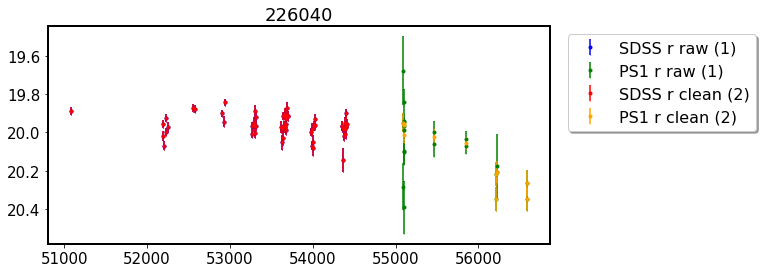

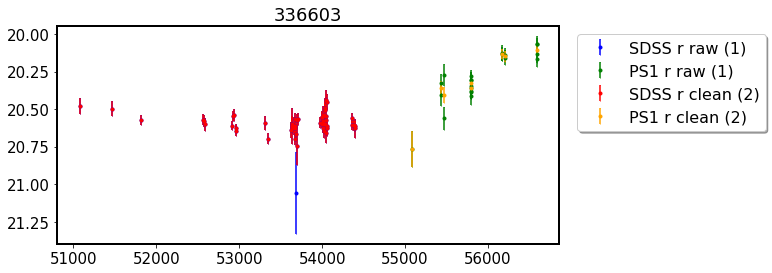

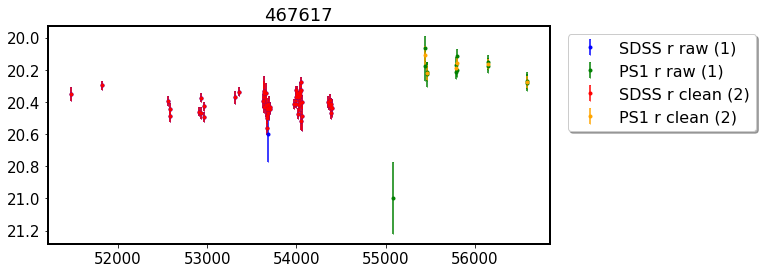

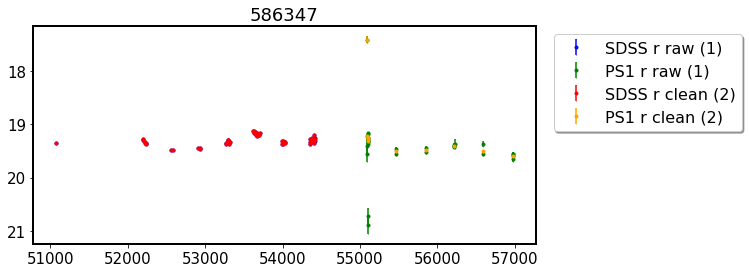

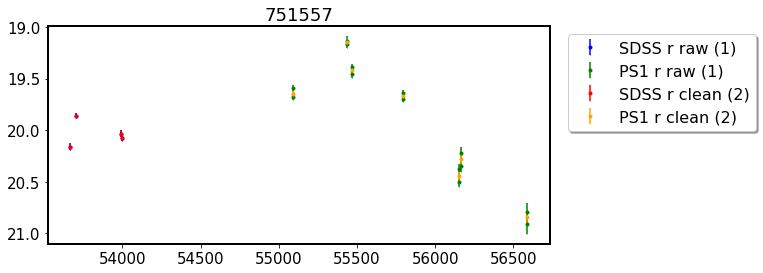

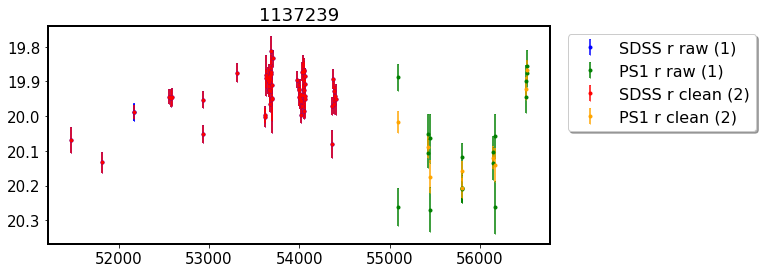

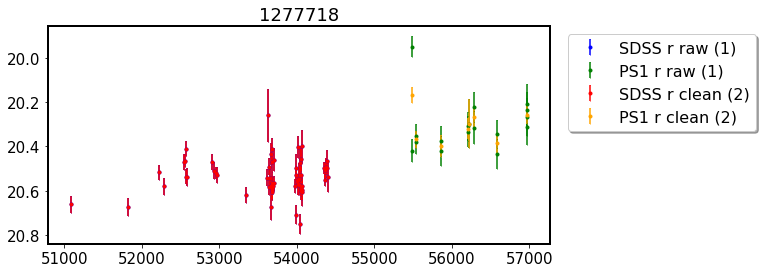

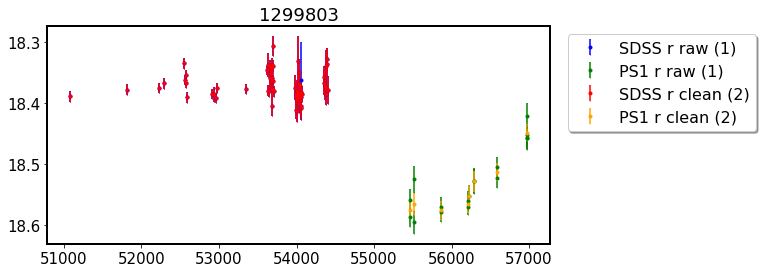

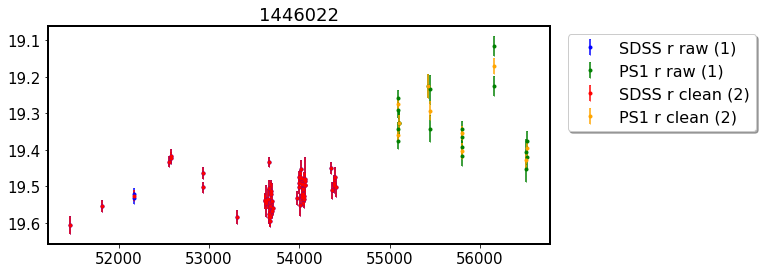

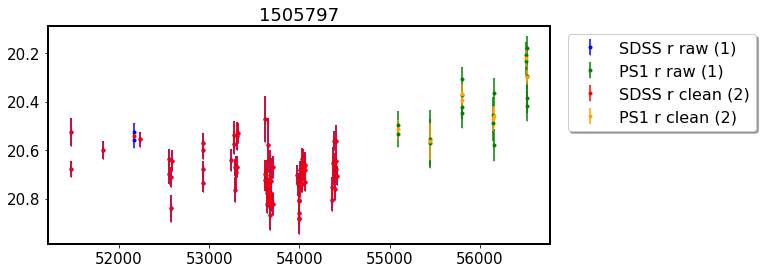

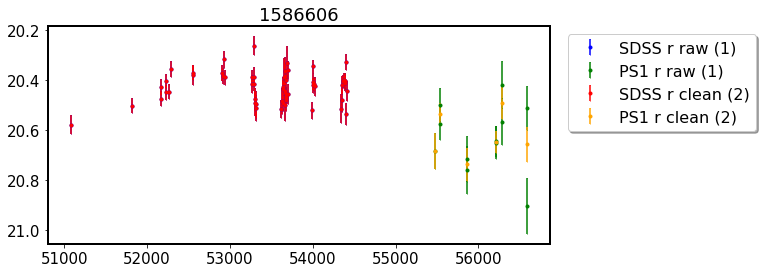

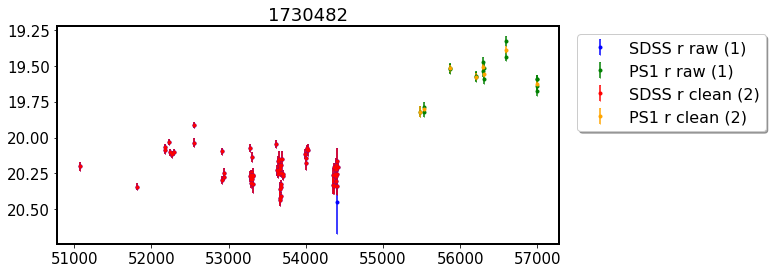

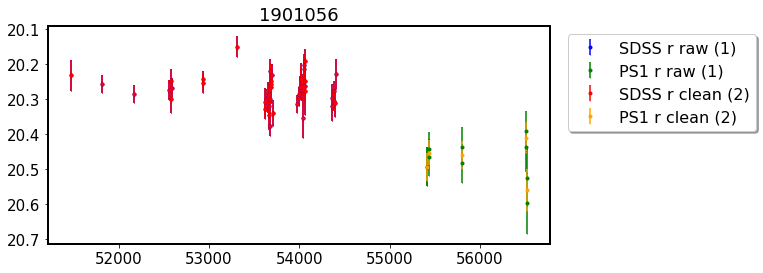

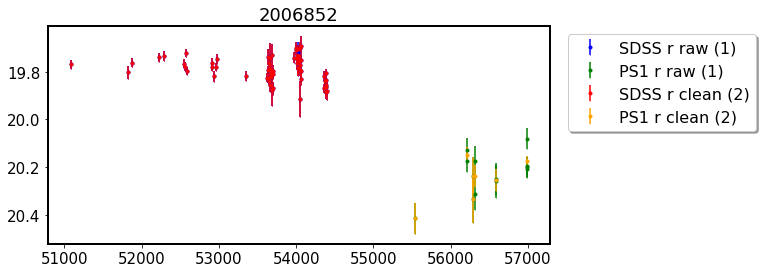

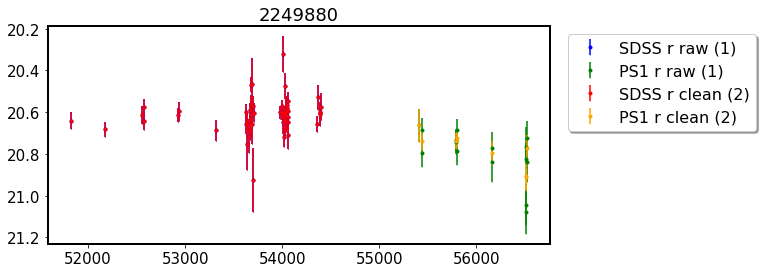

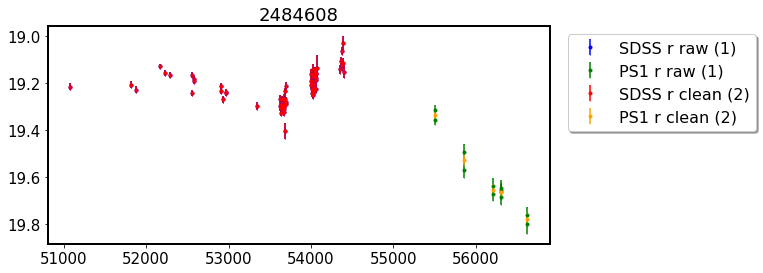

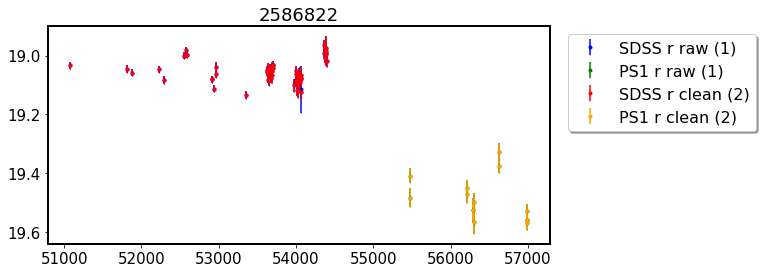

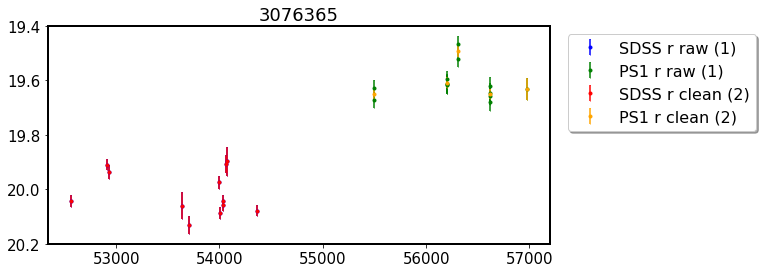

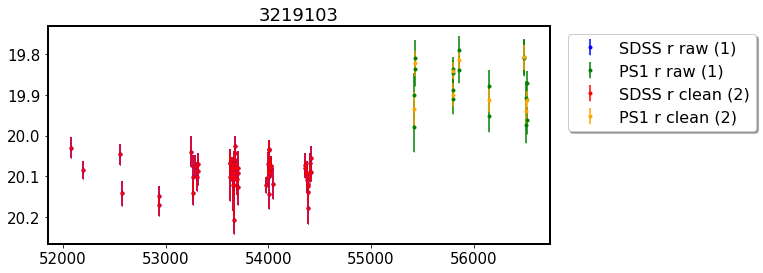

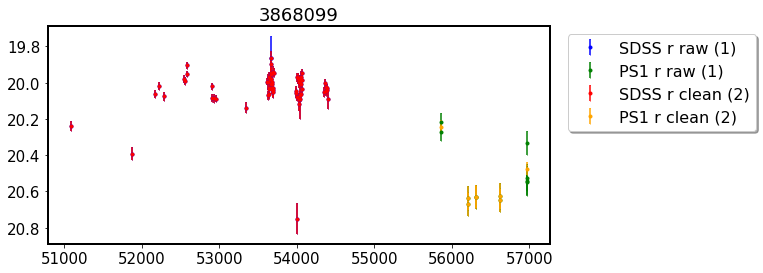

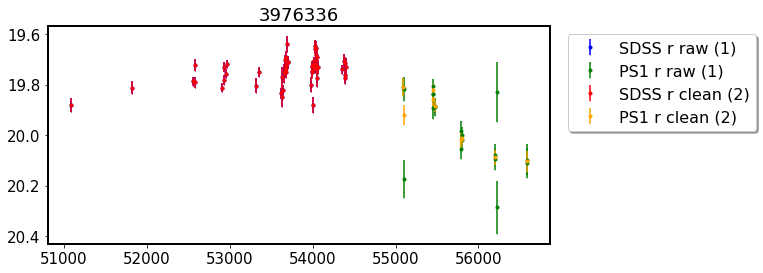

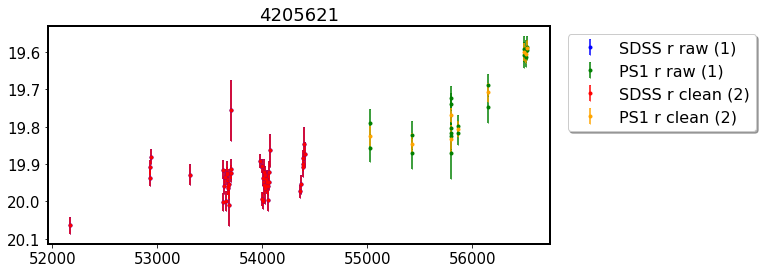

In [29]:
# Plot some light curves ... 
%matplotlib inline


rawDir = '../dp2/real_sdss_ps1r_dr2/'
intDir = '../dp2/real_sdss_ps1r_dr2_cleaning_NEW/'
finalDir = '../dp2/real_sdss_ps1r_dr2_cleaned_NEW/'

lcnames = data[maskObj]['lcname']

for i in range(len(lcnames)):
    print(i)
    lcname = lcnames[i]

    fig,ax = plt.subplots(1,1,figsize=(9,4))

    # plot the signal before cleaning (SDSS&PS1)
    lc = Table.read(rawDir+lcname, format='ascii')
    rows = lc['survey'] =='sdss'
    ax.errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                        fmt=".", capsize=0.2, label='SDSS r raw (1)',
                        c ='blue', )
    rows = lc['survey'] == 'ps1'
    ax.errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                    fmt=".", capsize=0.2, label='PS1 r raw (1)',
                    c ='green')
    
    # after cleaning:  
    lc = Table.read(finalDir+lcname, format='ascii')    

    # plot the clean SDSS
    rows = (lc['survey'] == 'sdss')
    ax.errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                    fmt=".", capsize=0.2, label='SDSS r clean (2)',
                    c ='red')
    
    # plot the clean PS1 
    rows = lc['survey'] == 'ps1'
    ax.errorbar(lc['mjd'][rows], lc['mag'][rows], lc['magerr'][rows], 
                        fmt=".", capsize=0.2, label='PS1 r clean (2)',
                        c ='orange')
    
    ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.02,1),
            ncol=1, fancybox=True, shadow=True, )
    ax.invert_yaxis()
    ax.set_title(lcname[:-4])
    plt.savefig('SDSS_PS1_DR2_190807_cleaned_'+lcname[:-4]+'.png', 
               bbox_inches='tight')
    #plt.clf()
    #plt.clf()

For tau>0, we have  8516  of  8516
For M10 good subset we have  6389  of  8516
Together we have  6389  of  8516
Saved as  Fig11_S20_M10_tau_sigma.pdf


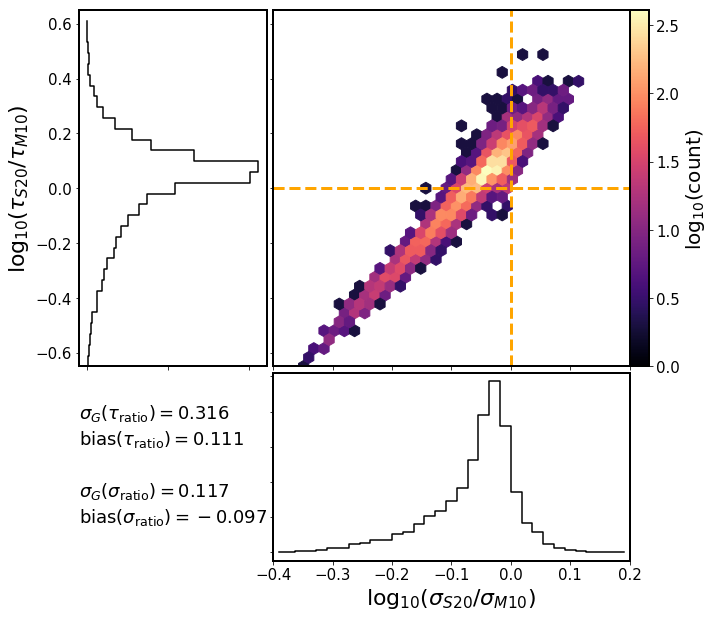

In [74]:
dataDir = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/'
date = '190807'#'190807'#'190606'#'190807'#'190807'
data = Table.read(dataDir + date+'_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
plot_tau_sigma_ratios(data, M10compare=True, rectangle = None,
                      figname = 'Fig11_S20_M10_tau_sigma.pdf' , 
                      figtitle = '', extent=[-0.4,0.2,-.65,.65]) 



8516  of  8516
For M10 good subset we have  6389  of  8516
Together we have  6389  of  8516
Saved as  Fig11_S20_M10_K_sigma-hat.pdf


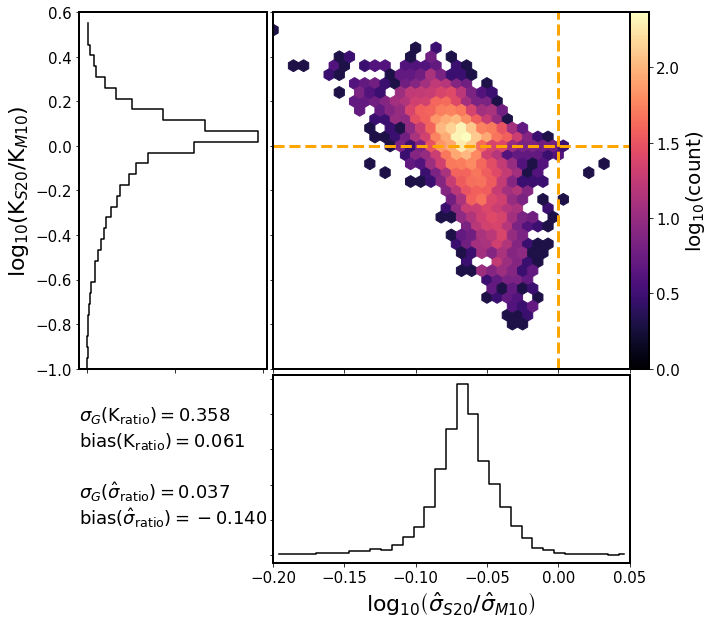

In [75]:
plot_K_sigma_hat(data, M10compare=True, rectangle = None,
                 figname = 'Fig11_S20_M10_K_sigma-hat.pdf',
                  extent = [-.2, .05, -1., 0.6 ], figtitle='')



NEXT: Count the number of objects  in the rectangle in observed and simulated data ... 

## FIG.12, 13 left panels : OBSERVED  S20 SDSS-PS1 / SDSS  <a id='fig12-13left'></a>

So the data is the same as for Fig.11, except we are not restricting ourselves to 6389 / 8516, but using all 8516 QSO for which we have SDSS-PS1 data 

In [53]:
dataDir = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/'
date = '190807'#'190807'#'190606'#'190807'#'190807'
data = Table.read(dataDir + date+'_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')

For tau>0, we have  8516  of  8516

There are 65 objects with x > 0.40, y > 1.00 

The are 48 objects in the rectangle
Saved as  Fig12_left_S20_tau_sigma.pdf


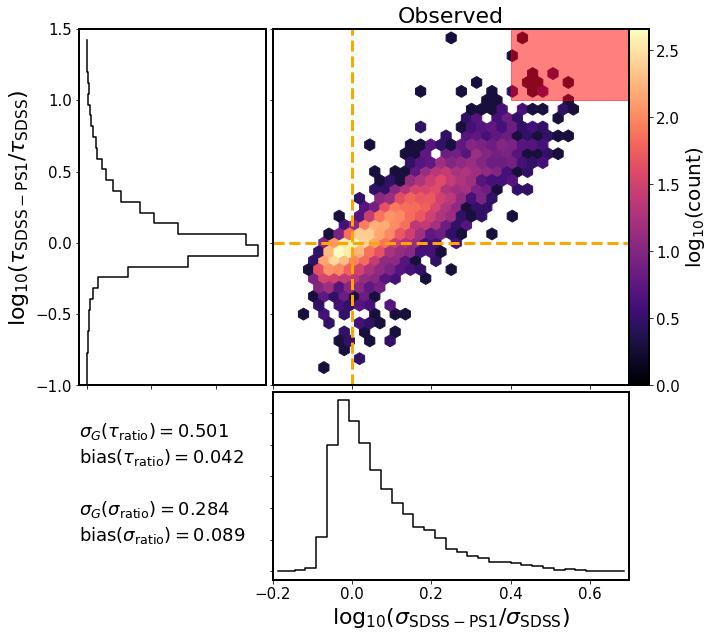

In [76]:

fig12_extent = [-0.2,0.7,-1,1.5]
fig12_13_left_title = 'Observed'

# Fig.12 , left panel 
plot_tau_sigma_ratios(data, M10compare=False, extent=fig12_extent, 
                      rectangle =  [0.4,1.0, 0.3,0.5], 
                      figname = 'Fig12_left_S20_tau_sigma.pdf' , 
                      figtitle = fig12_13_left_title, print_stats=True, 
                      choose_M10_subset=False, ) 



8516  of  8516
Saved as  Fig13_left_S20_M10_K_sigma-hat.pdf


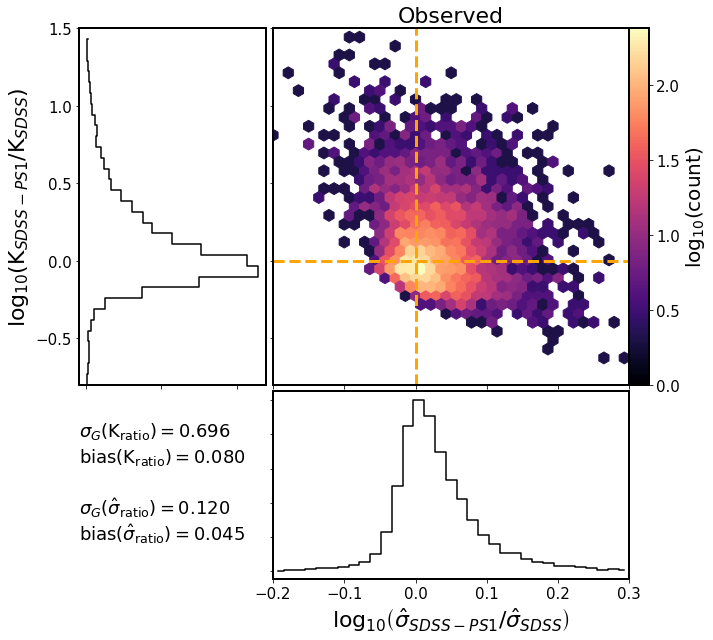

In [77]:
fig13_extent = [-.2, .3, -.8, 1.5 ]

# Fig.13 , left panel 
plot_K_sigma_hat(data, M10compare=False, extent = fig13_extent, 
                 rectangle = None, figname = 'Fig13_left_S20_M10_K_sigma-hat.pdf',
                 figtitle=fig12_13_left_title,  choose_M10_subset=False , )



## FIG.12, 13 right panels : SIMULATED  S20 SDSS-PS1 / SDSS    <a id='fig12-13right'></a>

For tau>0, we have  8516  of  8516

There are 29 objects with x > 0.40, y > 1.00 

The are 28 objects in the rectangle
Saved as  Fig12_right_S20_tau_sigma_rect.pdf


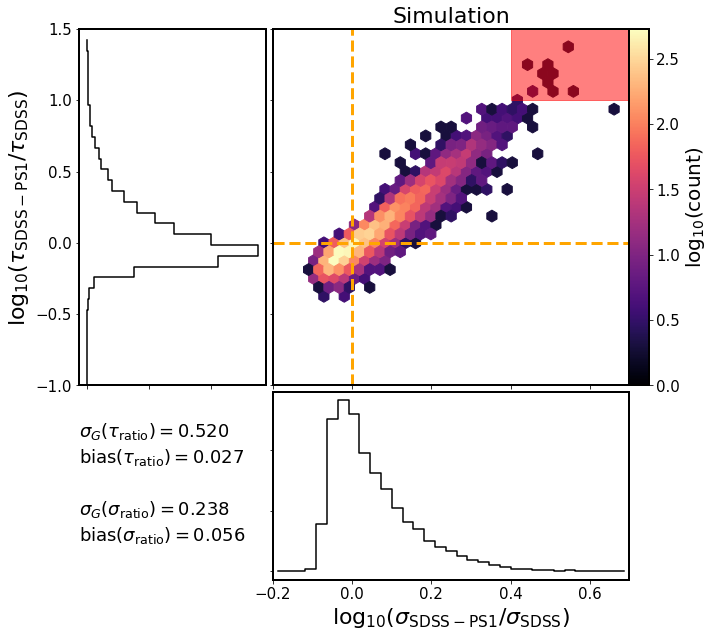

In [6]:
dataDir = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/'
data = Table.read(dataDir+'190612_Celerite_sim_w_LSST_ZTF_Jeff1.txt', format='ascii')

fig12_13_right_title = 'Simulation'
fig12_extent = [-0.2,0.7,-1,1.5]
# Fig, 12,  right panel 
plot_tau_sigma_ratios(data, M10compare=False, extent=fig12_extent, 
                      rectangle =  [0.4,1.0, 0.3,0.5], 
                      figname = 'Fig12_right_S20_tau_sigma_rect.pdf' , 
                      figtitle = fig12_13_right_title, print_stats=True, 
                      choose_M10_subset=False, ) 

8516  of  8516
Saved as  Fig13_right_S20_M10_K_sigma-hat.pdf


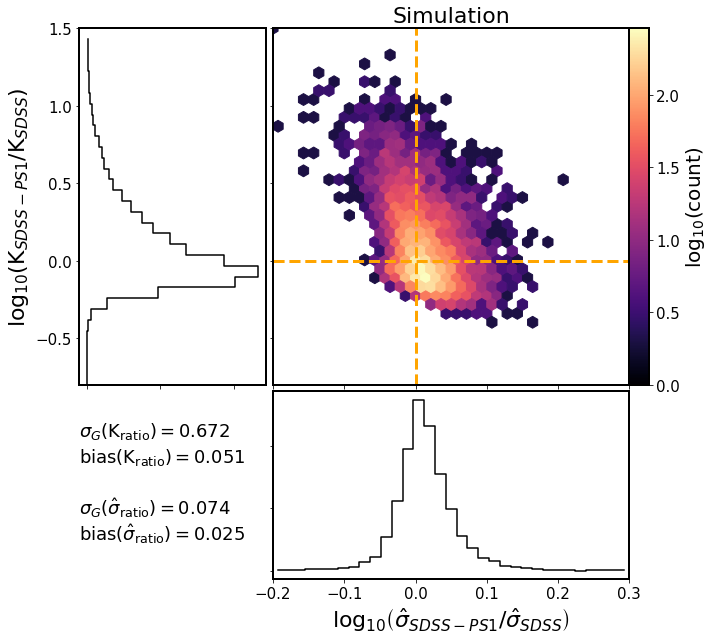

In [79]:
# Fig, 13,   right panel 
plot_K_sigma_hat(data, M10compare=False, extent = fig13_extent, 
                 rectangle = None, figname = 'Fig13_right_S20_M10_K_sigma-hat.pdf',
                 figtitle=fig12_13_right_title,  choose_M10_subset=False , )


8516  of  8516

There are 65 objects with x > 0.40, y > 1.00 

The are 48 objects in the rectangle
Saved as  Compare_Celerite_tau_sigma_ratios_r.png
8516  of  8516
Saved as  Compare_Celerite_K-sigma-hat_ratios.png


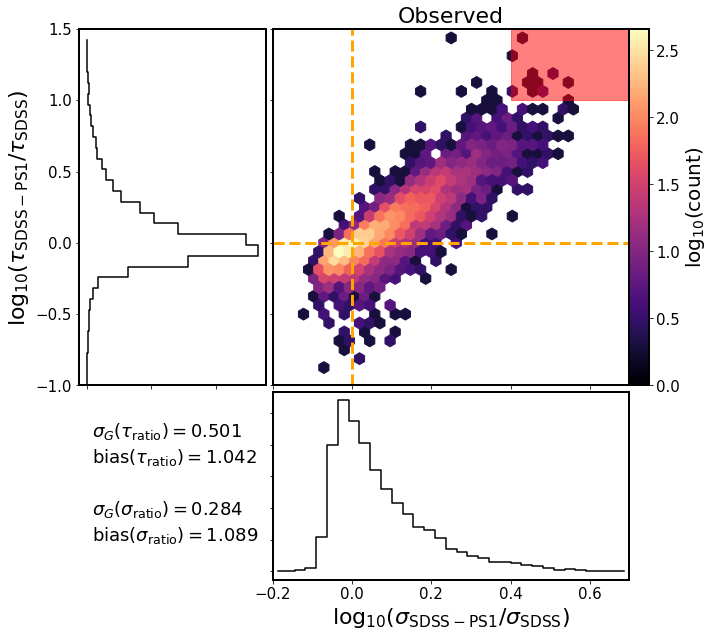

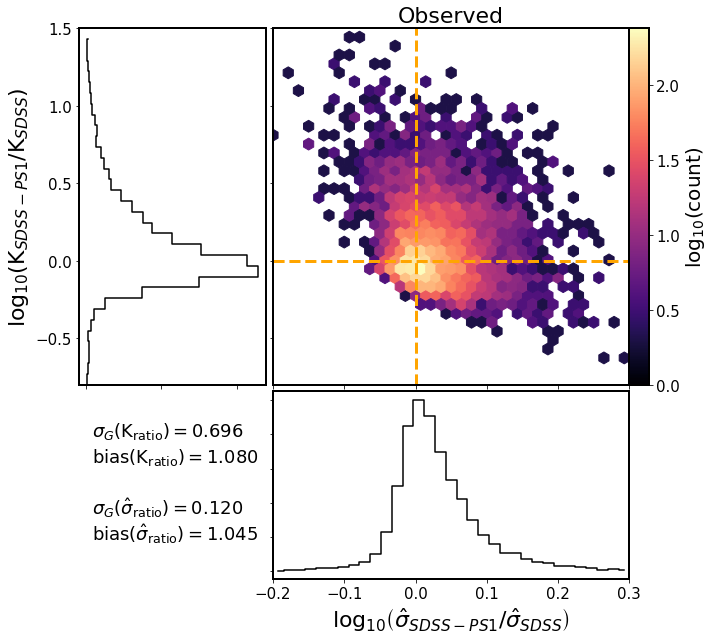

In [5]:

dataDir = '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code2/'
# for real results ,  plot both tau-sigma,  and K-sigma hat space 


# Comparison to M10  : FIG11 
data = Table.read(dataDir + '190807_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
plot_tau_sigma_ratios(data,
                      figname = 'Compare_Celerite_tau_sigma_ratios_r.png' , 
                      rectangle = [0.4,1.0, 0.3,0.5],
                      figtitle = 'Observed'
                     )

plot_K_sigma_hat(data, figname = 'Compare_Celerite_K-sigma-hat_ratios.png',
                  extent = [-.2, .3, -.8, 1.5 ], figtitle='Observed')




# do the same for simulation results  : FIG12 
data = Table.read(dataDir+'190612_Celerite_sim_w_LSST_ZTF_Jeff1.txt', format='ascii')
plot_tau_sigma_ratios(data,
                      figname = 'Simulation_Celerite_tau_sigma_ratios_r.png' ,
                      rectangle = [0.4,1.0, 0.3,0.5],
                      figtitle = 'Simulation'
                     )
plot_K_sigma_hat(data, figname = 'Simulation_Celerite_K-sigma-hat_ratios.png',
                 extent = [-.2, .3, -.8, 1.5 ], figtitle='Simulation')





In [12]:
data

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ztf,sigmaEXP_sdss-ps1-ztf,sigmaMAP_sdss-ps1-ztf,tauEXP_sdss-ps1-ztf,tauMAP_sdss-ps1-ztf,length_sdss-ps1-ztf-lsst,sigmaEXP_sdss-ps1-ztf-lsst,sigmaMAP_sdss-ps1-ztf-lsst,tauEXP_sdss-ps1-ztf-lsst,tauMAP_sdss-ps1-ztf-lsst
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1000679.txt,3336.9561299999987,0.17372380569999685,0.14026633970440283,901.2549220205265,330.65219754004096,5513.069991199998,0.15282895376187547,0.13037812507728735,678.8407344604589,280.18749728324053,7400.655313333336,0.21845250606638367,0.18569149099829815,1227.4811191286226,659.4407028340986,12510.862307827825,0.1637847722689818,0.14711022461483023,816.2739924648492,567.9502734496259
1000743.txt,3336.956146000004,0.1368924587173323,0.11364229981563599,723.5923276915645,353.7416432791509,5895.950533700001,0.12255502658653772,0.10747667325465646,543.5943333755741,321.6020935717062,7400.657342333339,0.15131190166993663,0.13083091378973663,875.7424246407091,516.1782708263167,12510.864336827828,0.1291083623879221,0.11829328695521081,549.7800744545492,413.1670880421176
1001265.txt,3327.0175859999945,0.1278473770005897,0.10958206741552913,463.3026806023565,197.7410369500242,5895.961819099997,0.10747136582652535,0.09860171296536265,268.47546522159604,159.89563408187433,7400.655709333332,0.12404974167730985,0.11187619238095613,479.14647545251535,283.1419594162298,12510.862703827821,0.12461025307166444,0.11425253895903822,498.73898645396235,373.9299516106872
1001294.txt,2582.9626130000033,0.15084302525421023,0.12043543886330232,1531.405683455064,524.551784773845,4767.9674503999995,0.1357906360823151,0.1121958933887647,1593.7357770746266,615.9820058621011,6656.606566333336,0.13042297576868905,0.11255240707400734,1193.5031875764898,478.4737479880702,11766.813560827824,0.16869247609249594,0.1490071255290454,1024.2387967242287,674.4181870157629
1001531.txt,3336.956121999996,0.11404255174058053,0.09745731459113148,391.3216028221721,170.4619483183812,5513.060385699995,0.14933624610888457,0.12947403146234374,568.5209292596268,284.80081094344246,7400.6579483333335,0.19186133221658042,0.16580416054642824,924.6413497443242,485.9177508890032,12510.864942827822,0.13531251570547467,0.12208295256598165,613.9590373536856,428.7406811391257
1001793.txt,3336.956118000002,0.13798294630388874,0.11219485650634964,770.0430220271859,328.31551934510287,5513.073767199996,0.20188379070898954,0.16428889860055934,1598.5436674195957,784.3138434721709,7400.659089333334,0.16774968464428502,0.14320815094112613,1080.31358039459,601.2152986756748,12510.866083827823,0.1317040047592262,0.12013870361914308,535.2161146350613,392.64765084894753
1002076.txt,3336.9563599999965,0.09311038573192731,0.0828844037832651,171.76671910186846,88.16585785223775,5895.991951399999,0.09531478998097968,0.08693735169040959,147.25353735575806,85.16096813221303,7400.660229333334,0.12675458478616947,0.11364257867846238,379.50947582515954,209.49963050433354,12510.867223827823,0.10826640914790464,0.1015805329496339,309.4753770330168,252.82746379652804
1002162.txt,3321.0338460000057,0.12802828308357597,0.11040904064842405,404.09403632822296,211.01920018006342,5890.0101001,0.12288515413195723,0.11140329607462993,352.2105781433354,229.79158497414556,7394.6790473333385,0.1395593150432647,0.12424084741992789,557.0684632894122,351.8876240233225,12504.886041827827,0.12972020463031236,0.11950693819136203,553.712588200369,424.9883798298049
1002453.txt,3321.033841999997,0.18996693882209073,0.1545414701446226,1885.0415070488611,1012.8098738811757,5506.039444399998,0.17245221574111386,0.1429220981440909,1788.9572979591867,979.4474526846004,7394.678560333334,0.15136941368925189,0.12847217477441006,1327.2824082964207,729.9711556690961,12504.885554827822,0.161229